In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

In [2]:
#read in file
orders = pd.read_excel('Analytics Interview Question_mobile_new.xlsx', sheet_name='Orders')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73688 entries, 0 to 73687
Data columns (total 13 columns):
Week                           73688 non-null object
Mobile Indicator Name          73688 non-null object
Platform Type Name             73688 non-null object
Super Region                   73688 non-null object
Country Name                   73688 non-null object
Booking Window Group           73688 non-null object
Property Country               73688 non-null object
Net Gross Booking Value USD    73688 non-null float64
Net Orders                     73688 non-null int64
start_lat                      71809 non-null float64
start_lon                      71809 non-null float64
stop_lat                       73688 non-null float64
stop_lon                       73688 non-null float64
dtypes: float64(5), int64(1), object(7)
memory usage: 7.3+ MB


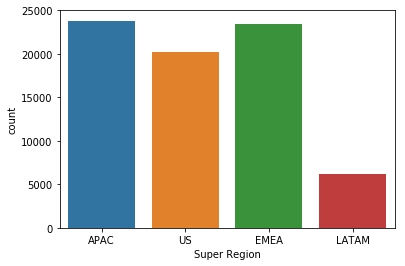

In [3]:
#look at initial distribution
sns.countplot(orders['Super Region'])

In [5]:
#read in file
visits = pd.read_excel('Analytics Interview Question_mobile_new.xlsx', sheet_name='Visits')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 6 columns):
Rpt Week                 168 non-null object
Super Region             168 non-null object
Country Name             168 non-null object
Mobile Indicator Name    168 non-null object
Platform Type Name       168 non-null object
Visits                   168 non-null int64
dtypes: int64(1), object(5)
memory usage: 8.0+ KB


In [7]:
#create a new column based on the year
orders['Year'] = orders['Week'].str.slice(0,4)
visits['Year'] = visits['Rpt Week'].str.slice(0,4)

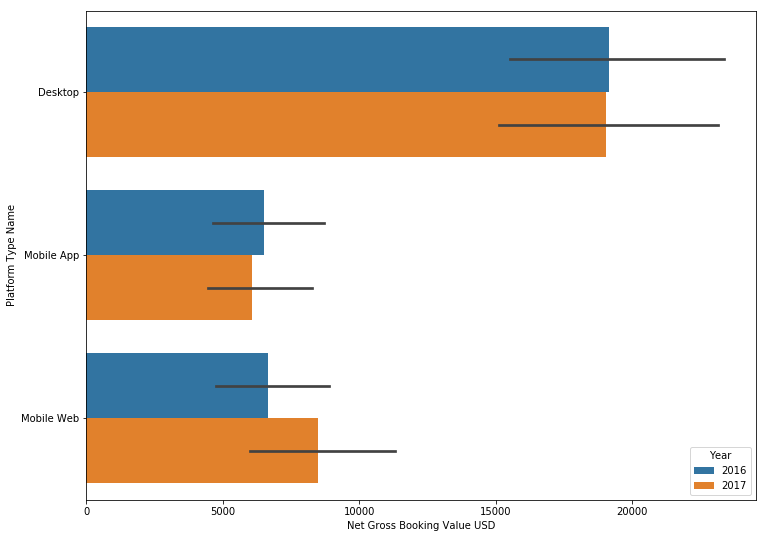

In [8]:
#initial data exploration
plt.figure(figsize=(12,9))
sns.barplot('Net Gross Booking Value USD', 'Platform Type Name', data = orders, hue = 'Year')

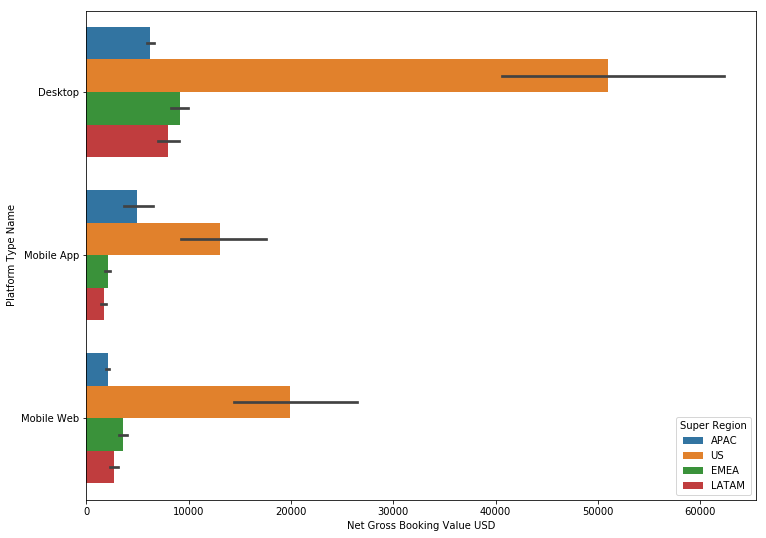

In [9]:
plt.figure(figsize=(12,9))
sns.barplot('Net Gross Booking Value USD', 'Platform Type Name', data=orders, hue='Super Region')

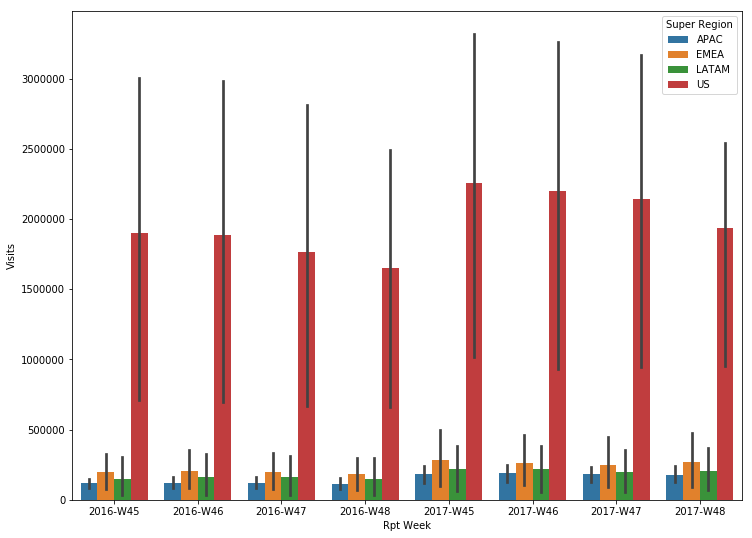

In [10]:
plt.figure(figsize=(12,9))
sns.barplot('Rpt Week', 'Visits', data=visits, hue='Super Region')

In [12]:
#import libraries for coordinates calculations
from geopy.distance import vincenty
from geopy.distance import great_circle

In [13]:
#testing out the distance calculation on a single row
start_lat = 13.444304
start_lon = 144.793731
stop_lat = 22.396428
stop_lon = 114.109497

start = (start_lat,start_lon)
stop = (stop_lat,stop_lon)

print(vincenty(start,stop).meters)
print(great_circle(start,stop).meters)

3390915.000190265
3387803.519921395


In [15]:
#function for calculating the distance
def distance_calc (orders):
    start = (orders['start_lat'], orders['start_lon'])
    stop = (orders['stop_lat'], orders['stop_lon'])
    
    return great_circle(start,stop).meters

In [16]:
#create new column using the distance function
orders['Distance'] = orders.apply(lambda orders: distance_calc (orders), axis=1)

In [17]:
#convert from metres to kilometres
orders['KM Distance'] = orders['Distance']/1000

In [18]:
orders.drop('Distance',axis=1,inplace=True)

In [20]:
orders.groupby(['Platform Type Name']).mean()

,Net Gross Booking Value USD,Net Orders,start_lat,start_lon,stop_lat,stop_lon,KM Distance
Platform Type Name,,,,,,,
Desktop,19685.557782,67.116798,24.505465,23.793449,31.010009,11.764514,7543.719501
Mobile App,6351.011005,27.921995,25.943972,30.256860,31.783088,14.447613,7156.917812
Mobile Web,7809.722951,38.051526,25.358257,27.225184,32.232487,8.919146,6845.737404


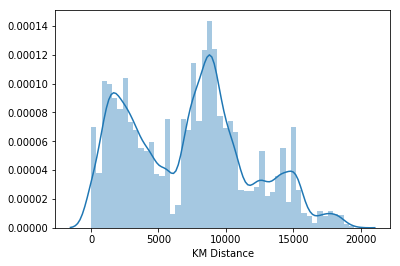

In [21]:
#distribution of distances
sns.distplot(orders['KM Distance'])

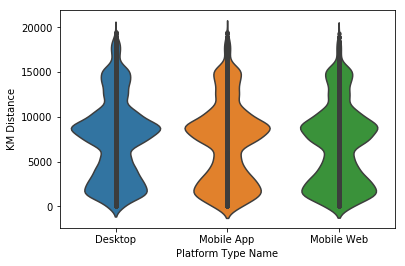

In [22]:
sns.violinplot('Platform Type Name', 'KM Distance', data = orders,inner='points')

In [23]:
#export back to Excel
orders.to_excel('ordersnew.xlsx')

In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71809 entries, 0 to 73687
Data columns (total 15 columns):
Week                           71809 non-null object
Mobile Indicator Name          71809 non-null object
Platform Type Name             71809 non-null object
Super Region                   71809 non-null object
Country Name                   71809 non-null object
Booking Window Group           71809 non-null object
Property Country               71809 non-null object
Net Gross Booking Value USD    71809 non-null float64
Net Orders                     71809 non-null int64
start_lat                      71809 non-null float64
start_lon                      71809 non-null float64
stop_lat                       71809 non-null float64
stop_lon                       71809 non-null float64
Year                           71809 non-null object
KM Distance                    71809 non-null float64
dtypes: float64(6), int64(1), object(8)
memory usage: 11.3+ MB


In [25]:
#create dummy variables on categorical data
hot_label = pd.get_dummies(orders['Booking Window Group'])
kmeans_data = pd.concat([hot_label,orders[['Net Gross Booking Value USD', 'KM Distance']]],axis=1)

In [26]:
#run kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2)
model = kmeans.fit(kmeans_data)
labels = model.predict(kmeans_data)
#this didn't work too well due to the aggregated data and minus bookings

In [27]:
orders['Booking Window Group'].unique()

array(['46-60 days', '+90 days', '61-90 days', '8-14 days', '4-7 days',
       '15-30 days', '31-45 days', '0-1 days', '2-3 days', 'Post Book'],
      dtype=object)

In [37]:
#create function to turn booking window in to a float, rather than a string
def booking_num(window):
    if window == '0-1 days':
        return 1
    elif window == '2-3 days':
        return 3
    elif window == '4-7 days':
        return 7
    elif window == '8-14 days':
        return 14
    elif window == '15-30 days':
        return 30
    elif window == '31-45 days':
        return 45
    elif window == '46-60 days': 
        return 60
    elif window == '61-90 days':
        return 90
    else:
        return 120

In [42]:
orders['window_num'] = orders['Booking Window Group'].apply(booking_num)

In [43]:
orders.head()

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,start_lat,start_lon,stop_lat,stop_lon,Year,KM Distance,window_num
0,2016-W45,Desktop,Desktop,APAC,Hong Kong,46-60 days,Guam,-22973.4200,-10,13.444304,144.793731,22.396428,114.109497,2016,3387.803520,60
1,2016-W45,Desktop,Desktop,US,United States,+90 days,Argentina,-1503.7500,-6,-38.416097,-63.616672,37.090240,-95.712891,2016,9017.693925,120
2,2016-W45,Mobile,Mobile App,APAC,South Korea,46-60 days,Guam,-4474.8480,-5,13.444304,144.793731,35.907757,127.766922,2016,3022.030268,60
3,2016-W45,Desktop,Desktop,EMEA,United Kingdom,61-90 days,Monaco,-1428.0342,-4,43.750298,7.412841,55.378051,-3.435973,2016,1507.328151,90
4,2016-W45,Desktop,Desktop,US,United States,61-90 days,Poland,407.8909,-4,51.919438,19.145136,37.090240,-95.712891,2016,8279.744611,90


In [45]:
#explore correlation. Didn't work too well due to aggregation.
np.corrcoef(orders['Net Gross Booking Value USD'], orders['window_num'])

array([[ 1.        , -0.01491909],
       [-0.01491909,  1.        ]])

In [53]:
orders.to_excel('ordersnew2.xlsx')